In [1]:
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import os
from skimage.io import imread

## Helper Functions

In [2]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def get_train_datapath():
    return glob('./data/train/train/*/*/flood_label/*.png')

def get_val_datapath():
    return glob('data/val_with_ref_labels/test/*/*/flood_label/*.png')

def cvtFpath(fpath, label):
    if label in ['vv', 'vh']:
        return '/'.join([tag if tag!='flood_label' else label for tag in fpath.split('/')])[:-4]+'_%s.png'%label
    else:
        return '/'.join([tag if tag!='flood_label' else label for tag in fpath.split('/')])
        
train_paths = get_train_datapath()
val_paths = get_val_datapath()

def show_datapoint(fpath):
    flood_layer = imread(fpath,0)
    vv = imread(cvtFpath(fpath, 'vv'),0)
    vh = imread(cvtFpath(fpath, 'vh'),0)
    water_layer = imread(cvtFpath(fpath, 'water_body_label'),0)
    visualize(vv=vv, vh=vh, water_layer=water_layer, flood_layer=flood_layer)

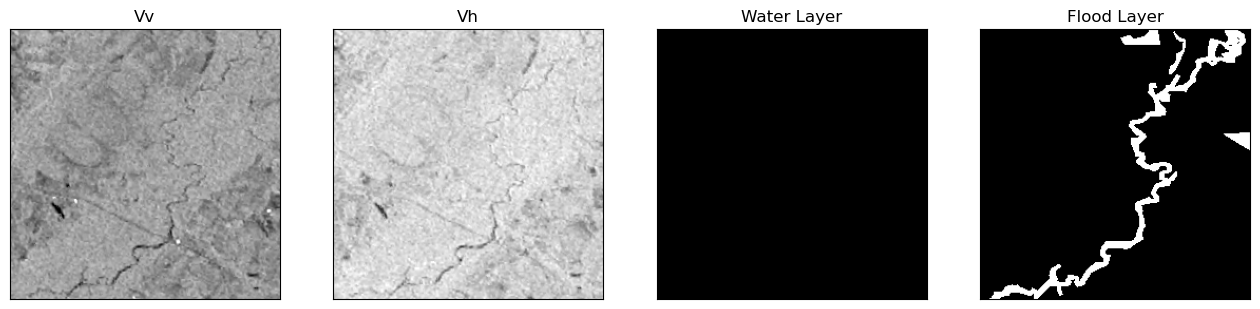

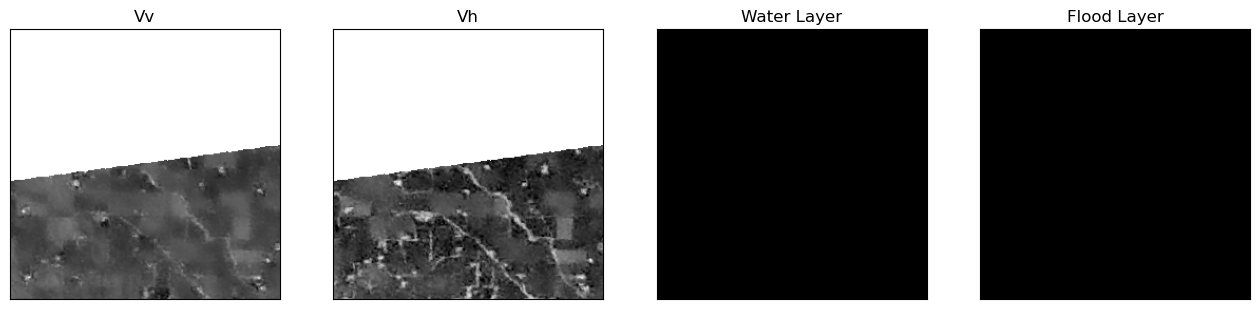

In [10]:
show_datapoint(train_paths[np.random.randint(len(train_paths))])

In [4]:
train_paths[0]

'./data/train/train/northal_20190606t234654/tiles/flood_label/northal_20190606t234654_x-1_y-13.png'

In [6]:
cvtFpath(train_paths[0], 'vv')

'./data/train/train/northal_20190606t234654/tiles/vv/northal_20190606t234654_x-1_y-13_vv.png'